# AAut lab question 2 part 1

## Image classification

# Initial steps
Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from imblearn.over_sampling import SMOTE
from PIL import Image

Load data

In [2]:
Xtest1 = np.load('Xtest1.npy')
Xtrain1 = np.load('Xtrain1.npy')
Xtrain1_extra = np.load('Xtrain1_extra.npy')
Ytrain1 = np.load('Ytrain1.npy')
Xtrain1_extra = Xtrain1_extra.reshape(-1, 48, 48, 1)
print(Xtrain1.shape, Xtrain1_extra.shape, Ytrain1.shape)

(2783, 2304) (904, 48, 48, 1) (2783,)


In [3]:
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []
    
    # Reshape the images from (2783, 2304) to (2783, 48, 48)
    reshaped_images = images.reshape(-1, 48, 48)
    
    for img, label in zip(reshaped_images, labels):
        pil_img = Image.fromarray(img)

        # Original image
        augmented_images.append(np.array(pil_img))
        # Horizontal flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_LEFT_RIGHT)))
        # Vertical flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_TOP_BOTTOM)))
        # Rotate 90 degrees
        augmented_images.append(np.array(pil_img.rotate(90)))
        # Rotate 180 degrees
        augmented_images.append(np.array(pil_img.rotate(180)))
        # Rotate 270 degrees
        augmented_images.append(np.array(pil_img.rotate(270)))
        # Zoom
        zoom_img = pil_img.resize((int(48 * 1.2), int(48 * 1.2))).crop((int(48 * 0.1), int(48 * 0.1), int(48 * 1.1), int(48 * 1.1)))
        augmented_images.append(np.array(zoom_img))
        # Shift width
        shift_width_img = pil_img.transform(pil_img.size, Image.AFFINE, (1, 0, 48 * 0.2, 0, 1, 0))
        augmented_images.append(np.array(shift_width_img))
        # Shift height
        shift_height_img = pil_img.transform(pil_img.size, Image.AFFINE, (1, 0, 0, 0, 1, 48 * 0.2))
        augmented_images.append(np.array(shift_height_img))
        # Append the label for each augmented image
        augmented_labels.extend([label] * 9)
    
    # Convert the augmented images back to the (num_images, 2304) format
    augmented_images = np.array(augmented_images).reshape(-1, 48 * 48)
    
    return augmented_images, augmented_labels

In [4]:
# Function to plot images
def plot_images(images, labels, num_images=20, extra=0):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap='gray')
        if extra:
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

Compute SMOTE (Synthetic Minority Over-sampling Technique) to deal with the low quantity of crater data

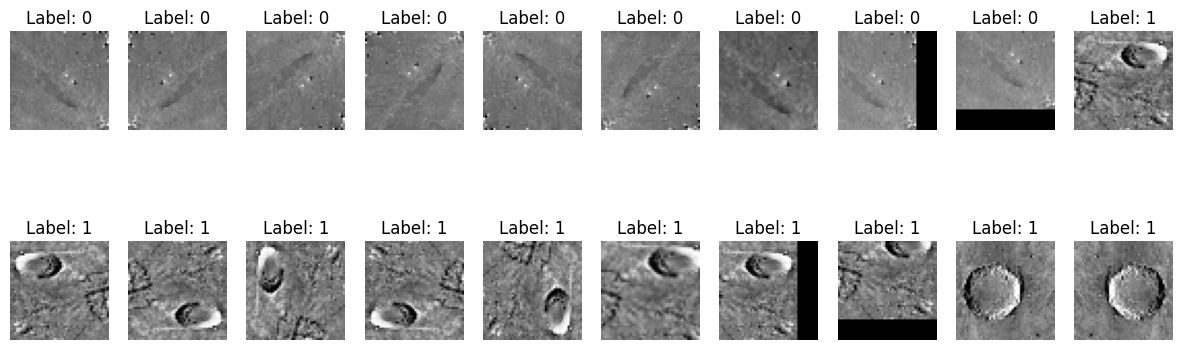

In [5]:
smote = SMOTE()

Xtrain_resampled, Ytrain_resampled = smote.fit_resample(Xtrain1, Ytrain1)

Xtrain_resampled, Ytrain_resampled = augment_images(Xtrain_resampled, Ytrain_resampled)

Xtrain_resampled = Xtrain_resampled.reshape(-1, 48, 48, 1)

plot_images(Xtrain_resampled, Ytrain_resampled, extra=1)

Split data into train and test

In [6]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xtrain_resampled, Ytrain_resampled, test_size=0.2, random_state=42)

# Convert labels to categorical (binary classification)
y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)

## Build CNNs

### CNN

In [7]:
# Build a simple CNN model
model_CNN = Sequential([
    Input(shape=(48, 48, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

### VGG16

In [8]:
# Load VGG16 model with pre-trained weights, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers of VGG16
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
vgg16_model = Sequential([
    Input(shape=(48, 48, 1)),
    Conv2D(3, (1, 1), activation='relu'),  # Convert grayscale to RGB
    vgg16_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

### ResNet50

In [9]:
# Load ResNet50 model with pre-trained weights, excluding the top layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers of ResNet50
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
resnet_model = Sequential([
    Input(shape=(48, 48, 1)),
    Conv2D(3, (1, 1), activation='relu'),  # Convert grayscale to RGB
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

## Train the models

Callbacks

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5)

### CNN

In [11]:
# Compile the model
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_CNN = model_CNN.fit(X_train, y_train_cat, validation_data=(X_train, y_train_cat), epochs=50, callbacks=[early_stopping, reduce_lr], batch_size=32)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6753 - loss: 1.3226 - val_accuracy: 0.7984 - val_loss: 0.4169 - learning_rate: 0.0010
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8479 - loss: 0.3747 - val_accuracy: 0.8551 - val_loss: 0.3337 - learning_rate: 0.0010
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.8658 - loss: 0.3328 - val_accuracy: 0.8963 - val_loss: 0.2494 - learning_rate: 0.0010
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8801 - loss: 0.2856 - val_accuracy: 0.8942 - val_loss: 0.2531 - learning_rate: 0.0010
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8929 - loss: 0.2566 - val_accuracy: 0.8897 - val_loss: 0.2608 - learning_rate: 0.0010
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9067 - loss: 0.2289 - val_accuracy: 0.9243 - val_loss: 0.1801 - learning_rate: 1.0000e-04
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9214

### VGG16


In [30]:
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16 model with data augmentation
history_vgg16 = vgg16_model.fit(X_train, y_train_cat, 
                                validation_data=(X_val, y_val_cat), 
                                epochs=20, 
                                callbacks=[early_stopping, reduce_lr], batch_size=32)

Epoch 1/20
210/800 ━━━━━━━━━━━━━━━━━━━━ 2:24 244ms/step - accuracy: 0.7938 - loss: 2.7309

KeyboardInterrupt: 

### ResNet50

In [ ]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model with data augmentation
history_resnet = resnet_model.fit(X_train, y_train_cat, 
                                  validation_data=(X_val, y_val_cat), 
                                  epochs=50, 
                                  callbacks=[early_stopping, reduce_lr], batch_size=32)

## Evaluation of the models

### CNN

In [12]:
# Evaluate the model on the validation set
y_val_pred_CNN = model_CNN.predict(X_val)
y_val_pred_classes_CNN = np.argmax(y_val_pred_CNN, axis=1)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### VGG16

In [ ]:
# Evaluate the VGG16 model on the validation set
y_val_pred_vgg16 = vgg16_model.predict(X_val)
y_val_pred_classes_vgg16 = np.argmax(y_val_pred_vgg16, axis=1)

### ResNet50

In [ ]:
# Evaluate the ResNet50 model on the validation set
y_val_pred_resnet = resnet_model.predict(X_val)
y_val_pred_classes_resnet = np.argmax(y_val_pred_resnet, axis=1)

In [13]:
# Calculate F1 Score
f1_CNN = f1_score(y_val, y_val_pred_classes_CNN)
print(f"Validation F1 Score: {f1_CNN} (CNN)")
f1_vgg16 = f1_score(y_val, y_val_pred_classes_vgg16)
print(f"Validation F1 Score: {f1_vgg16} (VGG16)")
f1_resnet = f1_score(y_val, y_val_pred_classes_resnet)
print(f"Validation F1 Score: {f1_resnet} (ResNet50)")

Validation F1 Score: 0.9234853216739538 (CNN)


NameError: name 'y_val_pred_classes_vgg16' is not defined

Confusion matrix

In [14]:
# Compute confusion matrix for CNN
cm_CNN = confusion_matrix(y_val, y_val_pred_classes_CNN)
print("Confusion Matrix for CNN:")
print(cm_CNN)

# Compute confusion matrix for VGG16
cm_vgg16 = confusion_matrix(y_val, y_val_pred_classes_vgg16)
print("Confusion Matrix for VGG16:")
print(cm_vgg16)

# Compute confusion matrix for ResNet50
cm_resnet = confusion_matrix(y_val, y_val_pred_classes_resnet)
print("Confusion Matrix for ResNet50:")
print(cm_resnet)

Confusion Matrix for CNN:
[[2951  242]
 [ 248 2957]]


NameError: name 'y_val_pred_classes_vgg16' is not defined

### Final predictions

In [15]:
Xtest1 = Xtest1.reshape(-1, 48, 48, 1)
predY_final = model_CNN.predict(Xtest1)
predY_classes_final = np.argmax(predY_final, axis=1)

# Save the predictions with np
np.save('predY_classes_final.npy', predY_classes_final)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
